In [3]:
import brax
import jax
from tqdm import tqdm
from jax import numpy as jp
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

In [3]:
from brax.io import mjcf

ball = mjcf.loads(
    """<mujoco>
         <option timestep="0.005"/>
         <worldbody>
           <body pos="0 0 3">
             <joint type="free"/>
             <geom size="0.5" type="sphere"/>
           </body>
           <geom size="40 40 40" type="plane"/>
         </worldbody>
       </mujoco>
  """)

In [4]:
print(ball.link.inertia.mass, 4/3 * jp.pi * 0.5**3 * 1000)

[523.59875] 523.5987755982989


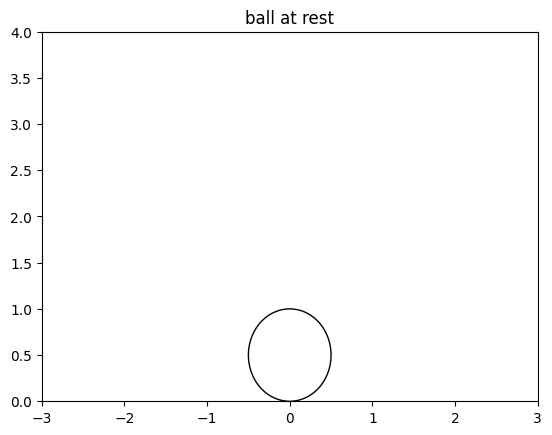

In [5]:
def visualize(ax, pos, alpha=1):
  for p, pn in zip(pos, list(pos[1:]) + [None]):
    ax.add_patch(Circle(xy=(p[0], p[2]), radius=0.5, fill=False, color=(0, 0, 0, alpha)))
    if pn is not None:
      ax.add_line(Line2D([p[0], pn[0]], [p[2], pn[2]], color=(1, 0, 0, alpha)))

_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([0, 4])

visualize(ax, [[0, 0, 0.5]])
plt.title('ball at rest')
plt.show()

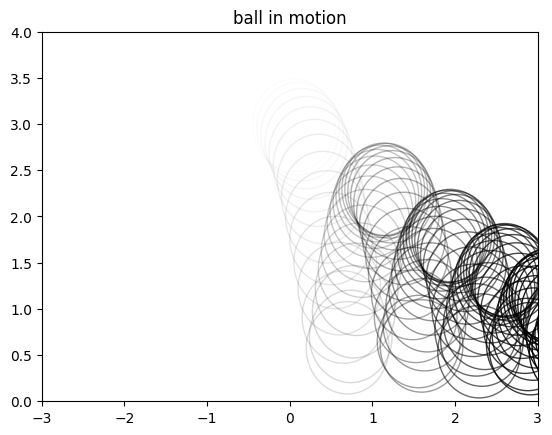

In [6]:
#@title { run: "auto"}
from brax.positional import pipeline

elasticity = 0.85 #@param { type:"slider", min: 0.5, max: 1.0, step:0.05 }
ball_velocity = 1 #@param { type:"slider", min:-5, max:5, step: 0.5 }

# change the material elasticity of the ball and the plane
geoms = [g.replace(elasticity=jp.array([elasticity])) for g in ball.geoms]
ball = ball.replace(geoms=geoms)

# provide an initial velocity to the ball
qd = jp.array([ball_velocity, 0, 0, 0, 0, 0])
state = jax.jit(pipeline.init)(ball, ball.init_q, qd)

_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([0, 4])

for i in range(1000):
  if i % 10 == 0:
    visualize(ax, state.x.pos, i / 1000.)
  state = jax.jit(pipeline.step)(ball, state, None)

plt.title('ball in motion')
plt.show()

In [1]:
import dm_control

In [2]:
import distutils.util
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

Wed Jun 14 19:08:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   39C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


In [4]:
print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del pixels, suite

Checking that the dm_control installation succeeded...


In [5]:
!echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

Installed dm_control 1.0.12


In [2]:
#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

/opt/conda/envs/bayes3d/lib/python3.9/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


In [7]:
#@title Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

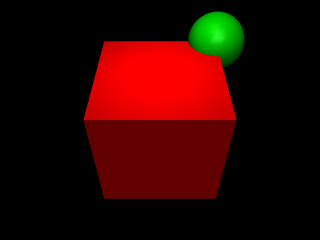

In [116]:
#@title A static model {vertical-output: true}

static_model = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(static_model)
pixels = physics.render()
PIL.Image.fromarray(pixels)

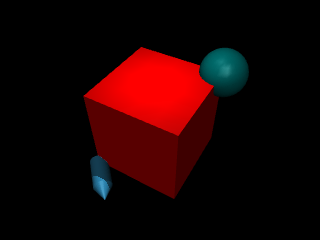

In [121]:
#@title A child body with a joint { vertical-output: true }

swinging_body = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">  
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 0.5 0.5 1"/>
    </body>
  </worldbody>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(swinging_body)
# Visualize the joint axis.
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True
pixels = physics.render(scene_option=scene_option)
PIL.Image.fromarray(pixels)

In [36]:
#@title Making a video {vertical-output: true}

duration = 8    # (seconds)
framerate = 30  # (Hz)

# Visualize the joint axis
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True

# Simulate and display video.
frames = []
physics.reset()  # Reset state and time
while physics.data.time < duration:
  physics.step()
  if len(frames) < physics.data.time * framerate:
    pixels = physics.render(scene_option=scene_option)
    frames.append(pixels)
display_video(frames, framerate)

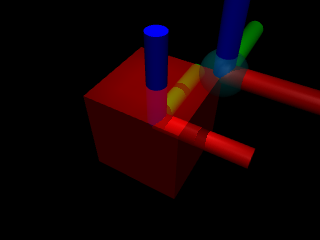

In [38]:
#@title Enable transparency and frame visualization {vertical-output: true}

scene_option = mujoco.wrapper.core.MjvOption()
scene_option.frame = enums.mjtFrame.mjFRAME_GEOM
scene_option.flags[enums.mjtVisFlag.mjVIS_TRANSPARENT] = True
pixels = physics.render(scene_option=scene_option)
PIL.Image.fromarray(pixels)

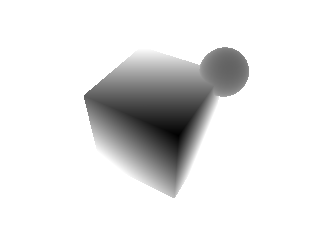

In [39]:
#@title Depth rendering {vertical-output: true}

# depth is a float array, in meters.
depth = physics.render(depth=True)
# Shift nearest values to the origin.
depth -= depth.min()
# Scale by 2 mean distances of near rays.
depth /= 2*depth[depth <= 1].mean()
# Scale to [0, 255]
pixels = 255*np.clip(depth, 0, 1)
PIL.Image.fromarray(pixels.astype(np.uint8))

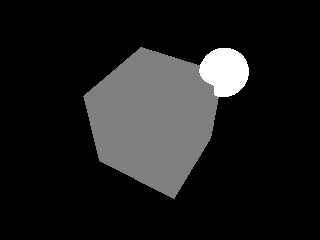

In [40]:
#@title Segmentation rendering {vertical-output: true}

seg = physics.render(segmentation=True)
# Display the contents of the first channel, which contains object
# IDs. The second channel, seg[:, :, 1], contains object types.
geom_ids = seg[:, :, 0]
# Infinity is mapped to -1
geom_ids = geom_ids.astype(np.float64) + 1
# Scale to [0, 1]
geom_ids = geom_ids / geom_ids.max()
pixels = 255*geom_ids
PIL.Image.fromarray(pixels.astype(np.uint8))


/opt/conda/envs/bayes3d/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


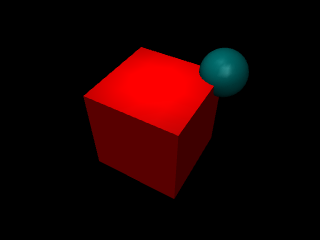

In [63]:
#@title Projecting from world to camera coordinates {vertical-output: true}

# Get the world coordinates of the box corners
box_pos = physics.named.data.geom_xpos['red_box']
box_mat = physics.named.data.geom_xmat['red_box'].reshape(3, 3)
box_size = physics.named.model.geom_size['red_box']
offsets = np.array([-1, 1]) * box_size[:, None]
xyz_local = np.stack(itertools.product(*offsets)).T
xyz_global = box_pos[:, None] + box_mat @ xyz_local

# Camera matrices multiply homogenous [x, y, z, 1] vectors.
corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)
corners_homogeneous[:3, :] = xyz_global

# Get the camera matrix.
camera = mujoco.Camera(physics)
camera_matrix = camera.matrix

# Project world coordinates into pixel space. See:
# https://en.wikipedia.org/wiki/3D_projection#Mathematical_formula
xs, ys, s = camera_matrix @ corners_homogeneous
# x and y are in the pixel coordinate system.
x = xs / s
y = ys / s

# Render the camera view and overlay the projected corner coordinates.
pixels = camera.render()
# fig, ax = plt.subplots(1, 1)
# ax.imshow(pixels)
# ax.plot(x, y, '+', c='w')
# ax.set_axis_off()
PIL.Image.fromarray(pixels.astype(np.uint8))


In [45]:
physics.model.geom_pos

array([[0. , 0. , 0. ],
       [0.2, 0.2, 0.2]])

In [51]:
print('timestep', physics.model.opt.timestep)
print('gravity', physics.model.opt.gravity)

timestep 0.002
gravity [ 0.    0.   -9.81]


In [52]:
print(physics.data.time, physics.data.qpos, physics.data.qvel)

0.0 [0.] [0.]


In [62]:
print(physics.named.data.geom_xpos)

FieldIndexer(geom_xpos):
                 x         y         z         
0      red_box [ 0         0         0       ]
1 green_sphere [ 0.273     0.0732    0.2     ]


In [61]:
print(physics.named.model.geom_pos)

FieldIndexer(geom_pos):
                 x         y         z         
0      red_box [ 0         0         0       ]
1 green_sphere [ 0.2       0.2       0.2     ]


In [66]:
physics.named.data.qpos['swing']

array([0.])

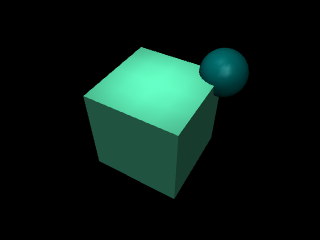

In [67]:
#@title Changing colors using named indexing{vertical-output: true}

random_rgb = np.random.rand(3)
physics.named.model.geom_rgba['red_box', :3] = random_rgb
pixels = physics.render()
PIL.Image.fromarray(pixels)

In [69]:
physics.named.data.qpos['swing'] = np.pi
print('Without reset_context, spatial positions are not updated:',
      physics.named.data.geom_xpos['green_sphere', ['z']])
with physics.reset_context():
  physics.named.data.qpos['swing'] = np.pi
print('After reset_context, positions are up-to-date:',
      physics.named.data.geom_xpos['green_sphere', ['z']])

Without reset_context, spatial positions are not updated: [-0.6]
After reset_context, positions are up-to-date: [-0.6]


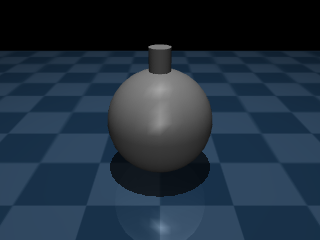

In [126]:
#@title The "tippe-top" model{vertical-output: true}

tippe_top = """
<mujoco model="tippe top">
  <option integrator="RK4"/>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" 
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>
  <worldbody>
    <geom size=".2 .2 .01" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
    <body name="top" pos="0 0 .02">
      <freejoint/>
      <geom name="ball" type="sphere" size=".02" />
      <geom name="stem" type="cylinder" pos="0 0 .02" size="0.004 .008"/>
      <geom name="ballast" type="box" size=".023 .023 0.005"  pos="0 0 -.015" 
       contype="0" conaffinity="0" group="3"/>
    </body>
  </worldbody>
  <keyframe>
    <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0.40 0 0 1 10" />
  </keyframe>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(tippe_top)
PIL.Image.fromarray(physics.render(camera_id='closeup'))

In [127]:
print('positions', physics.named.data.qpos)
print('velocities', physics.named.data.qvel)

positions FieldIndexer(qpos):
0  [ 0       ]
1  [ 0       ]
2  [ 0.02    ]
3  [ 1       ]
4  [ 0       ]
5  [ 0       ]
6  [ 0       ]
velocities FieldIndexer(qvel):
0  [ 0       ]
1  [ 0       ]
2  [ 0       ]
3  [ 0       ]
4  [ 0       ]
5  [ 0       ]


In [97]:
#@title Video of the tippe-top {vertical-output: true}

duration = 7    # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
physics.reset(0)  # Reset to keyframe 0 (load a saved state).
while physics.data.time < duration:
  physics.step()
  if len(frames) < (physics.data.time) * framerate:
    pixels = physics.render(camera_id='closeup')
    frames.append(pixels)

display_video(frames, framerate)

In [75]:
#@title Measuring values {vertical-output: true}

timevals = []
angular_velocity = []
stem_height = []

# Simulate and save data
physics.reset(0)
while physics.data.time < duration:
  physics.step()
  timevals.append(physics.data.time)
  angular_velocity.append(physics.data.qvel[3:6].copy())
  stem_height.append(physics.named.data.geom_xpos['stem', 'z'])

dpi = 100
width = 480
height = 640
figsize = (width / dpi, height / dpi)
_, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi, sharex=True)

ax[0].plot(timevals, angular_velocity)
ax[0].set_title('angular velocity')
ax[0].set_ylabel('radians / second')

ax[1].plot(timevals, stem_height)
ax[1].set_xlabel('time (seconds)')
ax[1].set_ylabel('meters')
_ = ax[1].set_title('stem height')

In [76]:
angular_velocity

[array([-5.06145975e-02,  9.43019014e-01,  1.99999928e+02]),
 array([-1.73489876e-01,  8.52466614e-01,  1.99999571e+02]),
 array([ -0.30446687,   0.79321451, 199.99901786]),
 array([ -0.42948973,   0.75981697, 199.99836997]),
 array([ -0.53957471,   0.74373608, 199.99774255]),
 array([ -0.63060364,   0.73571904, 199.99723021]),
 array([ -0.70240034,   0.72754072, 199.99688884]),
 array([ -0.75746567,   0.71303142, 199.99673038]),
 array([ -0.79968347,   0.6884501 , 199.99672841]),
 array([ -0.83321588,   0.65234962, 199.99683062]),
 array([ -0.86170696,   0.60511668, 199.99697424]),
 array([ -0.88782629,   0.54836386, 199.99710067]),
 array([ -0.91311886,   0.48431937, 199.99716681]),
 array([ -0.93808854,   0.41531433, 199.99715145]),
 array([ -0.96242709,   0.34341996, 199.99705634]),
 array([ -0.985305  ,   0.2702459 , 199.99690266]),
 array([-1.00565662e+00,  1.96880829e-01,  1.99996724e+02]),
 array([-1.02241454e+00,  1.23939017e-01,  1.99996558e+02]),
 array([-1.03467117e+00,  5.

In [98]:
class Leg(object):
  """A 2-DoF leg with position actuators."""
  def __init__(self, length, rgba):
    self.model = mjcf.RootElement()

    # Defaults:
    self.model.default.joint.damping = 2
    self.model.default.joint.type = 'hinge'
    self.model.default.geom.type = 'capsule'
    self.model.default.geom.rgba = rgba  # Continued below...

    # Thigh:
    self.thigh = self.model.worldbody.add('body')
    self.hip = self.thigh.add('joint', axis=[0, 0, 1])
    self.thigh.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/4])

    # Hip:
    self.shin = self.thigh.add('body', pos=[length, 0, 0])
    self.knee = self.shin.add('joint', axis=[0, 1, 0])
    self.shin.add('geom', fromto=[0, 0, 0, 0, 0, -length], size=[length/5])

    # Position actuators:
    self.model.actuator.add('position', joint=self.hip, kp=10)
    self.model.actuator.add('position', joint=self.knee, kp=10)

In [99]:
BODY_RADIUS = 0.1
BODY_SIZE = (BODY_RADIUS, BODY_RADIUS, BODY_RADIUS / 2)
random_state = np.random.RandomState(42)

def make_creature(num_legs):
  """Constructs a creature with `num_legs` legs."""
  rgba = random_state.uniform([0, 0, 0, 1], [1, 1, 1, 1])
  model = mjcf.RootElement()
  model.compiler.angle = 'radian'  # Use radians.

  # Make the torso geom.
  model.worldbody.add(
      'geom', name='torso', type='ellipsoid', size=BODY_SIZE, rgba=rgba)

  # Attach legs to equidistant sites on the circumference.
  for i in range(num_legs):
    theta = 2 * i * np.pi / num_legs
    hip_pos = BODY_RADIUS * np.array([np.cos(theta), np.sin(theta), 0])
    hip_site = model.worldbody.add('site', pos=hip_pos, euler=[0, 0, theta])
    leg = Leg(length=BODY_RADIUS, rgba=rgba)
    hip_site.attach(leg.model)

  return model

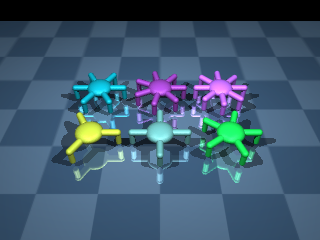

In [103]:
#@title Six Creatures on a floor.{vertical-output: true}

arena = mjcf.RootElement()
chequered = arena.asset.add('texture', type='2d', builtin='checker', width=300,
                            height=300, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
grid = arena.asset.add('material', name='grid', texture=chequered,
                       texrepeat=[5, 5], reflectance=.7)
arena.worldbody.add('geom', type='plane', size=[2, 2, .1], material=grid)
for x in [-2, 2]:
  arena.worldbody.add('light', pos=[x, -1, 3], dir=[-x, 1, -2])

# Instantiate 6 creatures with 3 to 8 legs.
creatures = [make_creature(num_legs=num_legs) for num_legs in range(3, 9)]

# Place them on a grid in the arena.
height = .15
grid = 5 * BODY_RADIUS
xpos, ypos, zpos = np.meshgrid([-grid, 0, grid], [0, grid], [height])
for i, model in enumerate(creatures):
  # Place spawn sites on a grid.
  spawn_pos = (xpos.flat[i], ypos.flat[i], zpos.flat[i])
  spawn_site = arena.worldbody.add('site', pos=spawn_pos, group=3)
  # Attach to the arena at the spawn sites, with a free joint.
  spawn_site.attach(model).add('freejoint')

# Instantiate the physics and render.
physics = mjcf.Physics.from_mjcf_model(arena)
PIL.Image.fromarray(physics.render())

In [104]:
#@title Video of the movement{vertical-output: true}
#@test {"timeout": 600}

duration = 10   # (Seconds)
framerate = 30  # (Hz)
video = []
pos_x = []
pos_y = []
torsos = []  # List of torso geom elements.
actuators = []  # List of actuator elements.
for creature in creatures:
  torsos.append(creature.find('geom', 'torso'))
  actuators.extend(creature.find_all('actuator'))

# Control signal frequency, phase, amplitude.
freq = 5
phase = 2 * np.pi * random_state.rand(len(actuators))
amp = 0.9

# Simulate, saving video frames and torso locations.
physics.reset()
while physics.data.time < duration:
  # Inject controls and step the physics.
  physics.bind(actuators).ctrl = amp * np.sin(freq * physics.data.time + phase)
  physics.step()

  # Save torso horizontal positions using bind().
  pos_x.append(physics.bind(torsos).xpos[:, 0].copy())
  pos_y.append(physics.bind(torsos).xpos[:, 1].copy())

  # Save video frames.
  if len(video) < physics.data.time * framerate:
    pixels = physics.render()
    video.append(pixels.copy())

display_video(video, framerate)

In [105]:
#@title The `Creature` class


class Creature(composer.Entity):
  """A multi-legged creature derived from `composer.Entity`."""
  def _build(self, num_legs):
    self._model = make_creature(num_legs)

  def _build_observables(self):
    return CreatureObservables(self)

  @property
  def mjcf_model(self):
    return self._model

  @property
  def actuators(self):
    return tuple(self._model.find_all('actuator'))


# Add simple observable features for joint angles and velocities.
class CreatureObservables(composer.Observables):

  @composer.observable
  def joint_positions(self):
    all_joints = self._entity.mjcf_model.find_all('joint')
    return observable.MJCFFeature('qpos', all_joints)

  @composer.observable
  def joint_velocities(self):
    all_joints = self._entity.mjcf_model.find_all('joint')
    return observable.MJCFFeature('qvel', all_joints)

In [106]:
#@title The `Button` class

NUM_SUBSTEPS = 25  # The number of physics substeps per control timestep.


class Button(composer.Entity):
  """A button Entity which changes colour when pressed with certain force."""
  def _build(self, target_force_range=(5, 10)):
    self._min_force, self._max_force = target_force_range
    self._mjcf_model = mjcf.RootElement()
    self._geom = self._mjcf_model.worldbody.add(
        'geom', type='cylinder', size=[0.25, 0.02], rgba=[1, 0, 0, 1])
    self._site = self._mjcf_model.worldbody.add(
        'site', type='cylinder', size=self._geom.size*1.01, rgba=[1, 0, 0, 0])
    self._sensor = self._mjcf_model.sensor.add('touch', site=self._site)
    self._num_activated_steps = 0

  def _build_observables(self):
    return ButtonObservables(self)

  @property
  def mjcf_model(self):
    return self._mjcf_model
  # Update the activation (and colour) if the desired force is applied.
  def _update_activation(self, physics):
    current_force = physics.bind(self.touch_sensor).sensordata[0]
    self._is_activated = (current_force >= self._min_force and
                          current_force <= self._max_force)
    physics.bind(self._geom).rgba = (
        [0, 1, 0, 1] if self._is_activated else [1, 0, 0, 1])
    self._num_activated_steps += int(self._is_activated)

  def initialize_episode(self, physics, random_state):
    self._reward = 0.0
    self._num_activated_steps = 0
    self._update_activation(physics)

  def after_substep(self, physics, random_state):
    self._update_activation(physics)

  @property
  def touch_sensor(self):
    return self._sensor

  @property
  def num_activated_steps(self):
    return self._num_activated_steps


class ButtonObservables(composer.Observables):
  """A touch sensor which averages contact force over physics substeps."""
  @composer.observable
  def touch_force(self):
    return observable.MJCFFeature('sensordata', self._entity.touch_sensor,
                                  buffer_size=NUM_SUBSTEPS, aggregator='mean')

In [107]:
#@title Random initialiser using `composer.variation`


class UniformCircle(variation.Variation):
  """A uniformly sampled horizontal point on a circle of radius `distance`."""
  def __init__(self, distance):
    self._distance = distance
    self._heading = distributions.Uniform(0, 2*np.pi)

  def __call__(self, initial_value=None, current_value=None, random_state=None):
    distance, heading = variation.evaluate(
        (self._distance, self._heading), random_state=random_state)
    return (distance*np.cos(heading), distance*np.sin(heading), 0)

In [108]:
#@title The `PressWithSpecificForce` task


class PressWithSpecificForce(composer.Task):

  def __init__(self, creature):
    self._creature = creature
    self._arena = floors.Floor()
    self._arena.add_free_entity(self._creature)
    self._arena.mjcf_model.worldbody.add('light', pos=(0, 0, 4))
    self._button = Button()
    self._arena.attach(self._button)

    # Configure initial poses
    self._creature_initial_pose = (0, 0, 0.15)
    button_distance = distributions.Uniform(0.5, .75)
    self._button_initial_pose = UniformCircle(button_distance)

    # Configure variators
    self._mjcf_variator = variation.MJCFVariator()
    self._physics_variator = variation.PhysicsVariator()

    # Configure and enable observables
    pos_corrptor = noises.Additive(distributions.Normal(scale=0.01))
    self._creature.observables.joint_positions.corruptor = pos_corrptor
    self._creature.observables.joint_positions.enabled = True
    vel_corruptor = noises.Multiplicative(distributions.LogNormal(sigma=0.01))
    self._creature.observables.joint_velocities.corruptor = vel_corruptor
    self._creature.observables.joint_velocities.enabled = True
    self._button.observables.touch_force.enabled = True

    def to_button(physics):
      button_pos, _ = self._button.get_pose(physics)
      return self._creature.global_vector_to_local_frame(physics, button_pos)

    self._task_observables = {}
    self._task_observables['button_position'] = observable.Generic(to_button)

    for obs in self._task_observables.values():
      obs.enabled = True

    self.control_timestep = NUM_SUBSTEPS * self.physics_timestep

  @property
  def root_entity(self):
    return self._arena

  @property
  def task_observables(self):
    return self._task_observables

  def initialize_episode_mjcf(self, random_state):
    self._mjcf_variator.apply_variations(random_state)

  def initialize_episode(self, physics, random_state):
    self._physics_variator.apply_variations(physics, random_state)
    creature_pose, button_pose = variation.evaluate(
        (self._creature_initial_pose, self._button_initial_pose),
        random_state=random_state)
    self._creature.set_pose(physics, position=creature_pose)
    self._button.set_pose(physics, position=button_pose)

  def get_reward(self, physics):
    return self._button.num_activated_steps / NUM_SUBSTEPS    

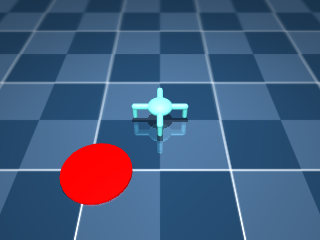

In [109]:
#@title Instantiating an environment{vertical-output: true}

creature = Creature(num_legs=4)
task = PressWithSpecificForce(creature)
env = composer.Environment(task, random_state=np.random.RandomState(42))

env.reset()
PIL.Image.fromarray(env.physics.render())

In [141]:
physics.data.contact

<_MjContactList
  H: array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])
  dim: array([3], dtype=int32)
  dist: array([0.])
  efc_address: array([-1], dtype=int32)
  exclude: array([1], dtype=int32)
  frame: array([[ 0.,  0.,  1.,  0.,  1.,  0., -1.,  0.,  0.]])
  friction: array([[1.e+00, 1.e+00, 5.e-03, 1.e-04, 1.e-04]])
  geom1: array([0], dtype=int32)
  geom2: array([1], dtype=int32)
  includemargin: array([0.])
  mu: array([0.])
  pos: array([[0., 0., 0.]])
  solimp: array([[9.0e-01, 9.5e-01, 1.0e-03, 5.0e-01, 2.0e+00]])
  solref: array([[0.02, 1.  ]])
>

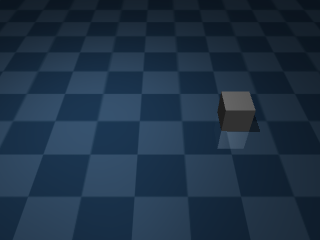

In [28]:
# a simple ball throwing demo

thrown_ball = """
<mujoco model="thrown_ball">
  <visual>
    <global offwidth="480" offheight="640"/>
  </visual>
  <option integrator="RK4"/>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" 
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".1"/>
  </asset>
  <worldbody>
    <geom size=".5 .5 .01" type="plane" material="grid" friction="0.01"/>
    <light pos="0 0 .6"/>
    <body name="ball" pos="0.2 0 .02">
      <freejoint/>
      <geom name="ball" type="box" size=".02 .02 .02" solref="-100000 -100" friction="0"/>
    </body>
  </worldbody>
  <keyframe>
    <key name="spinning" qpos="0.2 0 0.1 1 0 0 0" qvel="-0.2 0 1 0 0 0" />
  </keyframe>
</mujoco>
"""

physics = mujoco.Physics.from_xml_string(thrown_ball)
PIL.Image.fromarray(physics.render())

In [239]:
# thrown_ball = """
# <mujoco model="thrown_ball">
#   <worldbody>
#     <geom type="plane" size="1 1 .1"/>
#     <body pos="0 0 1">
#       <freejoint/>
#       <geom type="sphere" size="0.1" solref="-100000 -100"/>
#     </body>
#   </worldbody>
# </mujoco>

# """
# physics = mujoco.Physics.from_xml_string(thrown_ball)

duration = 4    # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
physics.reset(0)  # Reset to keyframe 0 (load a saved state).
while physics.data.time < duration:
  physics.step()
  if len(frames) < (physics.data.time) * framerate:
    pixels = physics.render()
    frames.append(pixels)

display_video(frames, framerate)

In [42]:
# Model element from MJCF

model = mjcf.RootElement()
body = model.worldbody.add('body')
body.add('geom', name='ball', pos = [0,0,1], size="0.1", rgba=[1,0,0,1])
chequered = model.asset.add('texture', type='2d', builtin='checker', width=300,
                            height=300, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
grid = model.asset.add('material', name='grid', texture=chequered,
                       texrepeat=[5, 5], reflectance=.2)
model.worldbody.add('geom', type='plane', size=[2, 2, .1], material=grid)
model.worldbody.add('light', pos=[0, -1, 3], dir=[0, 1, -2])
model.keyframe.add('key', name="throw", qpos="0.2 0 0.1 1 0 0 0", qvel=[-0.2, 0, 1, 0, 0, 0])
# [0.2, 0, 0.1, 1, 0, 0, 0]

MJCF Element: <key name="throw" qpos="0.20000000000000001 0 0.10000000000000001 1 0 0 0" qvel="-0.20000000000000001 0 1 0 0 0"/>

In [50]:
a = model.to_xml_string()#
# physics = mjcf.Physics.from_mjcf_model(model)
# PIL.Image.fromarray(physics.render())

In [ ]:
#@title Six Creatures on a floor.{vertical-output: true}

arena = mjcf.RootElement()
chequered = arena.asset.add('texture', type='2d', builtin='checker', width=300,
                            height=300, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
grid = arena.asset.add('material', name='grid', texture=chequered,
                       texrepeat=[5, 5], reflectance=.2)
arena.worldbody.add('geom', type='plane', size=[2, 2, .1], material=grid)
for x in [-2, 2]:
  arena.worldbody.add('light', pos=[x, -1, 3], dir=[-x, 1, -2])

# Instantiate 6 creatures with 3 to 8 legs.
creatures = [make_creature(num_legs=num_legs) for num_legs in range(3, 9)]

# Place them on a grid in the arena.
height = .15
grid = 5 * BODY_RADIUS
xpos, ypos, zpos = np.meshgrid([-grid, 0, grid], [0, grid], [height])
for i, model in enumerate(creatures):
  # Place spawn sites on a grid.
  spawn_pos = (xpos.flat[i], ypos.flat[i], zpos.flat[i])
  spawn_site = arena.worldbody.add('site', pos=spawn_pos, group=3)
  # Attach to the arena at the spawn sites, with a free joint.
  spawn_site.attach(model).add('freejoint')

# Instantiate the physics and render.
physics = mjcf.Physics.from_mjcf_model(arena)
PIL.Image.fromarray(physics.render())

In [6]:
#@title All `dm_control` imports required for this tutorial
%env MUJOCO_GL=egl
# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

#@title Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)


env: MUJOCO_GL=egl


In [5]:
%env['MUJOCO_GL']

UsageError: Line magic function `%env['MUJOCO_GL']` not found.


In [29]:
mjcf_model = mjcf.from_xml_string(thrown_ball)

In [39]:
mjcf_model.keyframe.key[0].qpos

array([0.2, 0. , 0.1, 1. , 0. , 0. , 0. ])

In [52]:
print(a)

<mujoco model="unnamed_model">
  <default>
    <default class="/"/>
  </default>
  <asset>
    <texture name="//unnamed_texture_0" type="2d" builtin="checker" rgb1="0.20000000000000001 0.29999999999999999 0.40000000000000002" rgb2="0.29999999999999999 0.40000000000000002 0.5" width="300" height="300"/>
    <material name="grid" class="/" texture="//unnamed_texture_0" texrepeat="5 5" reflectance="0.20000000000000001"/>
  </asset>
  <worldbody>
    <body name="//unnamed_body_0">
      <geom name="ball" class="/" size="0.10000000000000001" rgba="1 0 0 1" pos="0 0 1"/>
    </body>
    <geom name="//unnamed_geom_1" class="/" type="plane" size="2 2 0.10000000000000001" material="grid"/>
    <light name="//unnamed_light_0" class="/" pos="0 -1 3" dir="0 1 -2"/>
  </worldbody>
  <keyframe>
    <key name="throw" qpos="0.20000000000000001 0 0.10000000000000001 1 0 0 0" qvel="-0.20000000000000001 0 1 0 0 0"/>
  </keyframe>
</mujoco>

